In [ ]:
%pip install langchain langchain-community langchain-core langgraph openai

In [ ]:
import sqlite3

# Conecta ao banco de dados (será criado se não existir)
conn = sqlite3.connect('vendas.db')
cursor = conn.cursor()

In [ ]:
# Cria a tabela 'produtos' se ela não existir
cursor.execute('''
CREATE TABLE IF NOT EXISTS produtos (
    produto_id INTEGER PRIMARY KEY,
    nome TEXT NOT NULL,
    preco REAL NOT NULL
)
''')

# Cria a tabela 'filiais' se ela não existir
cursor.execute('''
CREATE TABLE IF NOT EXISTS filiais (
    filial_id INTEGER PRIMARY KEY,
    nome TEXT NOT NULL,
    localizacao TEXT NOT NULL
)
''')

# Cria a tabela 'vendas' se ela não existir
cursor.execute('''
CREATE TABLE IF NOT EXISTS vendas (
    venda_id INTEGER PRIMARY KEY,
    produto_id INTEGER,
    filial_id INTEGER,
    quantidade_vendida INTEGER NOT NULL,
    data_venda DATE NOT NULL,
    FOREIGN KEY (produto_id) REFERENCES produtos (produto_id),
    FOREIGN KEY (filial_id) REFERENCES filiais (filial_id)
)
''')

# Confirma as alterações
conn.commit()

In [ ]:
# Inserir dados na tabela 'produtos'
produtos = [
    (1, 'Notebook', 3500.00),
    (2, 'Smartphone', 2000.00),
    (3, 'Tablet', 1500.00),
    (4, 'Monitor', 800.00),
    (5, 'Teclado', 150.00)
]

cursor.executemany('INSERT OR IGNORE INTO produtos VALUES (?, ?, ?)', produtos)

# Inserir dados na tabela 'filiais'
filiais = [
    (1, 'Filial Centro', 'São Paulo'),
    (2, 'Filial Norte', 'Rio de Janeiro'),
    (3, 'Filial Sul', 'Porto Alegre')
]

cursor.executemany('INSERT OR IGNORE INTO filiais VALUES (?, ?, ?)', filiais)

# Inserir dados na tabela 'vendas'
vendas = [
    (1, 1, 1, 10, '2023-01-15'),
    (2, 2, 1, 5, '2023-01-16'),
    (3, 3, 2, 7, '2023-01-17'),
    (4, 1, 2, 3, '2023-01-18'),
    (5, 4, 3, 4, '2023-01-19'),
    (6, 5, 3, 20, '2023-01-20'),
    (7, 2, 1, 6, '2023-01-21'),
    (8, 3, 2, 8, '2023-01-22'),
    (9, 4, 3, 2, '2023-01-23'),
    (10, 5, 1, 15, '2023-01-24')
]

cursor.executemany('INSERT OR IGNORE INTO vendas VALUES (?, ?, ?, ?, ?)', vendas)

# Confirma as alterações
conn.commit()

# Aviso sobre dados existentes
print("Dados inseridos ou ignorados se já existentes.")

In [ ]:
# Consultar todos os produtos
cursor.execute('SELECT * FROM produtos')
produtos = cursor.fetchall()
print('Produtos:')
for produto in produtos:
    print(produto)

# Consultar todas as filiais
cursor.execute('SELECT * FROM filiais')
filiais = cursor.fetchall()
print('\nFiliais:')
for filial in filiais:
    print(filial)

# Consultar todas as vendas
cursor.execute('SELECT * FROM vendas')
vendas = cursor.fetchall()
print('\nVendas:')
for venda in vendas:
    print(venda)

In [ ]:
# Fecha a conexão com o banco de dados
conn.close()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
#from langchain.chat_models import ChatOpenAI
from langchain_community.llms import Ollama
from langgraph.graph import StateGraph, END
from langchain.schema import SystemMessage, HumanMessage
from typing import TypedDict, List
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [ ]:
model = Ollama(model="gemma2:2b")

In [ ]:
class AgentState(TypedDict):
    question: str
    table_schemas: str
    database: str
    sql: str
    reflect: List[str]
    accepted: bool
    revision: int
    max_revision: int

In [ ]:
def get_database_schema(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    schema = ''
    for table_name in tables:
        table_name = table_name[0]
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        schema += f"Table: {table_name}\n"
        schema += "Columns:\n"
        for column in columns:
            schema += f" - {column[1]} ({column[2]})\n"
        schema += '\n'
    conn.close()
    return schema

# Obter o esquema do banco de dados
db_schema = get_database_schema('vendas.db')
print(db_schema)

In [ ]:
def search_engineer_node(state: AgentState):
    # Fornecemos o esquema do banco de dados diretamente
    state['table_schemas'] = db_schema
    state['database'] = 'vendas.db'
    return {"table_schemas": state['table_schemas'], "database": state['database']}

In [ ]:
def senior_sql_writer_node(state: AgentState):
    role_prompt = """
Você é um especialista em SQL. Sua tarefa é escrever **apenas** a consulta SQL que responda à pergunta do usuário. A consulta deve:

- Usar a sintaxe SQL padrão em inglês.
- Utilizar os nomes das tabelas e colunas conforme definidos no esquema do banco de dados.
- Não incluir comentários, explicações ou qualquer texto adicional.
- Não utilizar formatação de código ou markdown.
- Retornar apenas a consulta SQL válida.
"""
    instruction = f"Esquema do banco de dados:\n{state['table_schemas']}\n"
    if len(state['reflect']) > 0:
        instruction += f"Considere os seguintes feedbacks:\n{chr(10).join(state['reflect'])}\n"
    instruction += f"Escreva a consulta SQL que responda à seguinte pergunta: {state['question']}\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = model.generate([prompt]).generations[0][0].text
    return {"sql": response.strip(), "revision": state['revision'] + 1}

In [ ]:
#Função do QA Engineer
def senior_qa_engineer_node(state: AgentState):
    role_prompt = """
Você é um engenheiro de QA especializado em SQL. Sua tarefa é verificar se a consulta SQL fornecida responde corretamente à pergunta do usuário.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Verifique se a consulta SQL pode completar a tarefa: {state['question']}\n"
    instruction += "Responda 'ACEITO' se estiver correta ou 'REJEITADO' se não estiver.\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = model.generate([prompt]).generations[0][0].text
    return {"accepted": 'ACEITO' in response.upper()}

In [ ]:
#Função do Chief DBA
def chief_dba_node(state: AgentState):
    role_prompt = """
Você é um DBA experiente. Sua tarefa é fornecer feedback detalhado para melhorar a consulta SQL fornecida.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Por favor, forneça recomendações úteis e detalhadas para ajudar a melhorar a consulta SQL para a tarefa: {state['question']}\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = model.generate([prompt]).generations[0][0].text
    return {"reflect": [response]}

In [ ]:
builder = StateGraph(AgentState)

# Adicionar nós
builder.add_node("search_engineer", search_engineer_node)
builder.add_node("sql_writer", senior_sql_writer_node)
builder.add_node("qa_engineer", senior_qa_engineer_node)
builder.add_node("chief_dba", chief_dba_node)

# Adicionar arestas
builder.add_edge("search_engineer", "sql_writer")
builder.add_edge("sql_writer", "qa_engineer")
builder.add_edge("chief_dba", "sql_writer")

# Adicionar arestas condicionais
builder.add_conditional_edges(
    "qa_engineer", 
    lambda state: END if state['accepted'] or state['revision'] >= state['max_revision'] else "reflect", 
    {END: END, "reflect": "chief_dba"}
)

# Definir ponto de entrada
builder.set_entry_point("search_engineer")

# Compilar o grafo
graph = builder.compile()

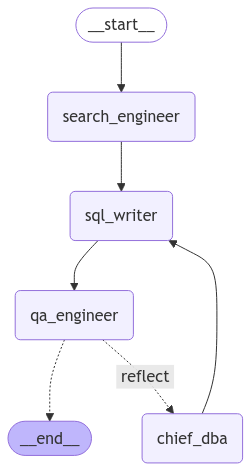

In [26]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# Configurar o checkpointer usando MemorySaver
memory = MemorySaver()

In [ ]:
# Compilar o grafo com o checkpointer
graph = builder.compile(checkpointer=memory)

In [ ]:
# Definir a pergunta
question = "Qual produto vendida na Filial Norte?"

# Inicializar o estado
initial_state = {
    'question': question,
    'table_schemas': '',  # Será preenchido pelo 'search_engineer_node'
    'database': '',       # Será preenchido pelo 'search_engineer_node'
    'sql': '',
    'reflect': [],
    'accepted': False,
    'revision': 0,
    'max_revision': 2
}

# Executar o grafo
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(initial_state, thread):
    pass  # O processamento é feito internamente

# Obter o estado final
state = graph.get_state(thread)

In [27]:
print('Banco de dados:', state.values['database'])
print('Consulta SQL:\n', state.values['sql'])

Banco de dados: vendas.db
Consulta SQL:
 ```sql
SELECT nome
FROM produtos
JOIN vendas ON produtos.produto_id = vendas.produto_id 
WHERE vendas.filial_id IN (SELECT filial_id FROM filiais WHERE nome='Norte');  
```


In [28]:
import re

def extract_sql(query_text):
    # Remove trechos de texto antes e depois da consulta SQL
    # Procura por conteúdo entre ```sql e ```
    match = re.search(r'```sql\s*(.*?)\s*```', query_text, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    else:
        # Se não encontrar, tenta extrair a partir de "SELECT"
        match = re.search(r'(SELECT .*?);', query_text, re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip() + ';'
        else:
            # Caso não consiga extrair, retorna o texto original
            return query_text.strip()

In [29]:
# Extrair a consulta SQL limpa
clean_sql = extract_sql(state.values['sql'])
print('Consulta SQL Extraída:\n', clean_sql)

# Executar a consulta SQL
try:
    db_path = 'vendas.db'
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(clean_sql)
    results = cursor.fetchall()
    print('\nResultados da consulta:')
    for result in results:
        print(result)
    conn.close()
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

Consulta SQL Extraída:
 SELECT nome
FROM produtos
JOIN vendas ON produtos.produto_id = vendas.produto_id 
WHERE vendas.filial_id IN (SELECT filial_id FROM filiais WHERE nome='Norte');

Resultados da consulta:


In [ ]:
import sqlite3

# Conectar ao banco de dados
conn = sqlite3.connect(state.values['database'])
cursor = conn.cursor()

# Executar a consulta SQL
try:
    cursor.execute(state.values['sql'])
    results = cursor.fetchall()
    print('\n Resultados da consulta:')
    for result in results:
        print(result)
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

# Fechar a conexão
conn.close()

In [ ]:
# Definir a pergunta
question = "Qual produto teve a maior quantidade vendida na Filial Sul?"

# Inicializar o estado
initial_state = {
    'question': question,
    'table_schemas': '',  # Será preenchido pelo 'search_engineer_node'
    'database': '',       # Será preenchido pelo 'search_engineer_node'
    'sql': '',
    'reflect': [],
    'accepted': False,
    'revision': 0,
    'max_revision': 2
}

# Executar o grafo
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(initial_state, thread):
    pass  # O processamento é feito internamente

# Obter o estado final
state = graph.get_state(thread)

In [ ]:
# Extrair a consulta SQL limpa
clean_sql = extract_sql(state.values['sql'])
print('Consulta SQL Extraída:\n', clean_sql)

# Executar a consulta SQL
try:
    cursor.execute(clean_sql)
    results = cursor.fetchall()
    print('\nResultados da consulta:')
    for result in results:
        print(result)
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

In [ ]:
import sqlite3

# Conectar ao banco de dados
conn = sqlite3.connect(state.values['database'])
cursor = conn.cursor()

# Executar a consulta SQL
try:
    cursor.execute(state.values['sql'])
    results = cursor.fetchall()
    print('\n Resultados da consulta:')
    for result in results:
        print(result)
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

# Fechar a conexão
conn.close()

In [ ]:
# Definir a pergunta
question = "Qual produto tem o maior preço entre todos as Filiais?"

# Inicializar o estado
initial_state = {
    'question': question,
    'table_schemas': '',  # Será preenchido pelo 'search_engineer_node'
    'database': '',       # Será preenchido pelo 'search_engineer_node'
    'sql': '',
    'reflect': [],
    'accepted': False,
    'revision': 0,
    'max_revision': 2
}

# Executar o grafo
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(initial_state, thread):
    pass  # O processamento é feito internamente

# Obter o estado final
state = graph.get_state(thread)

In [ ]:
# Extrair a consulta SQL limpa
clean_sql = extract_sql(state.values['sql'])
print('Consulta SQL Extraída:\n', clean_sql)

# Executar a consulta SQL
try:
    cursor.execute(clean_sql)
    results = cursor.fetchall()
    print('\nResultados da consulta:')
    for result in results:
        print(result)
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

In [ ]:
import sqlite3

# Conectar ao banco de dados
conn = sqlite3.connect(state.values['database'])
cursor = conn.cursor()

# Executar a consulta SQL
try:
    cursor.execute(state.values['sql'])
    results = cursor.fetchall()
    print('\n Resultados da consulta:')
    for result in results:
        print(result)
except Exception as e:
    print('Erro ao executar a consulta SQL:', e)

# Fechar a conexão
conn.close()